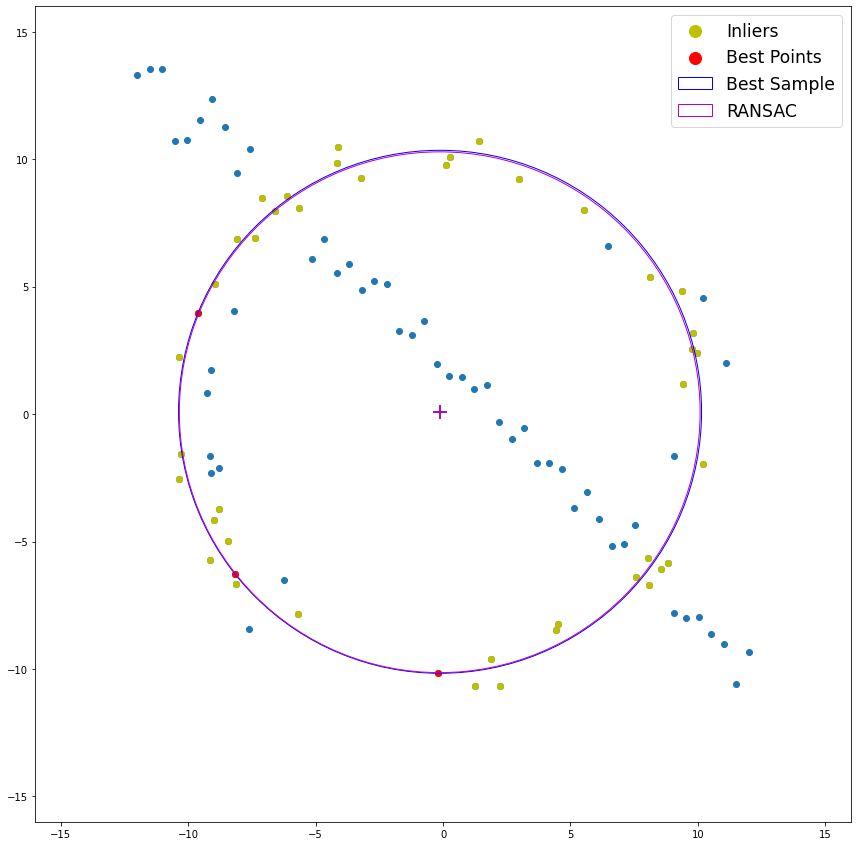

In [167]:
#Q1
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
from scipy import optimize
import matplotlib.pyplot as plt
import random

N = 100
half_n = N//2
r = 10
s = r/16
t = np.random.uniform(0, 2*np.pi, half_n)
n = s*np.random.randn(half_n)
x , y = (r + n)*np.cos(t) , (r + n)*np.sin(t)
X_circ= np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1) , y.reshape(half_n, 1)))
X = np.vstack((X_circ, X_line))

def Estimatecircle(min_iterations, min_inliers, no_of_points, points, inlier_treshold):
    its = min_iterations
    max_inliers = 0
    while max_inliers < min_inliers or its > 0:
        sample = random.sample(range(1, no_of_points), 3) # Randomly choose 3 points
        x1 = np.zeros([3,2])
        for i in range(3):
            x1[i]=points[sample[i]]
        
        x2 = np.hstack((x1,np.ones((3,1))))# Calculate the coordinates of the center & the radius of the circle passing through those 3 points
        x3 = (-1*((x1[:,0]*x1[:,0])+(x1[:,1]*x1[:,1]))).reshape(3,1)
        c = np.matmul(np.linalg.inv(x2),x3)
        c_x , c_y = -c[0]/2 , -c[1]/2
        radius = np.sqrt(c_x*c_x + c_y*c_y - c[2])

        if radius > 30:continue
        
        no_of_inliers, inlier_points = inlierCount(points, c_x, c_y, radius, inlier_treshold) # Find inliers
        if max_inliers < no_of_inliers:
            max_inliers, parameters, best_inliers, best_sample = no_of_inliers, [c_x,c_y,radius], inlier_points, x1
        if max_inliers >= min_inliers:
            its-=1
    
    return max_inliers, parameters, best_inliers, best_sample
    
    

def isInlier(x, y, cx, cy, r, T):# Function for Check for inliers
    r_=(x-cx)**2+(y-cy)**2
    if r-T < np.sqrt(r_) < r+T:
        return True
    else: return False

def inlierCount(points, cx, cy, r, T):# Function for Find inliers
    n=0
    inlier_arr=np.zeros((1,2))
    for i in points:
        if isInlier(i[0], i[1], cx, cy, r, T):
            n+=1
            if not inlier_arr.any():
                inlier_arr[0]=i
            else:
                inlier_arr=np.concatenate((inlier_arr,[i]),axis=0)
    return n,inlier_arr

def findcenter(xc, yc):#finding center (xc, yc)
    return np.sqrt((x-xc)**2 + (y-yc)**2)

def f_2(c):# distance between the data points and the mean circle
    Ri = findcenter(*c)
    return Ri - Ri.mean()

def leastSquareCirc(x,y):   # least square circle fit

    center_estimate = np.mean(x),np.mean(y)
    center_2, ier = optimize.leastsq(f_2, center_estimate)
    xc_2, yc_2 = center_2
    Ri_2 = findcenter(*center_2)
    R_2 = Ri_2.mean()
    residu_2 = sum((Ri_2 - R_2)**2)
    return round(xc_2,5),round(yc_2,5),round(R_2,5),residu_2

m1, circle_param, inlier_points, bestpoints = Estimatecircle(250,42,N,X,0.9)
x, y = inlier_points[:,0],inlier_points[:,1]

figure, axes = plt.subplots(figsize=(15,15))

# plotting
draw = plt.Circle((circle_param[0], circle_param[1]), circle_param[2],fill=False,color='b',label='Best Sample')
axes.scatter(X[:,0], X[:,1]) 
axes.scatter(circle_param[0], circle_param[1],color='b',marker='+',s=180) 
axes.scatter(x, y,color='y',label='Inliers') 
axes.scatter(bestpoints[:,0], bestpoints[:,1],color='r',label='Best Points')
axes.set_aspect(1)
axes.add_artist(draw)

a,b,c,d = leastSquareCirc(x,y) 

draw = plt.Circle((a, b), c,fill=False,color='m',label='RANSAC') 
axes.add_artist(draw)
axes.scatter(a, b,marker='+',c='m',s=180) #
plt.xlim(-16,16)
plt.ylim(-16,16)
plt.legend(fontsize='xx-large',markerscale=2.0)
plt.show()

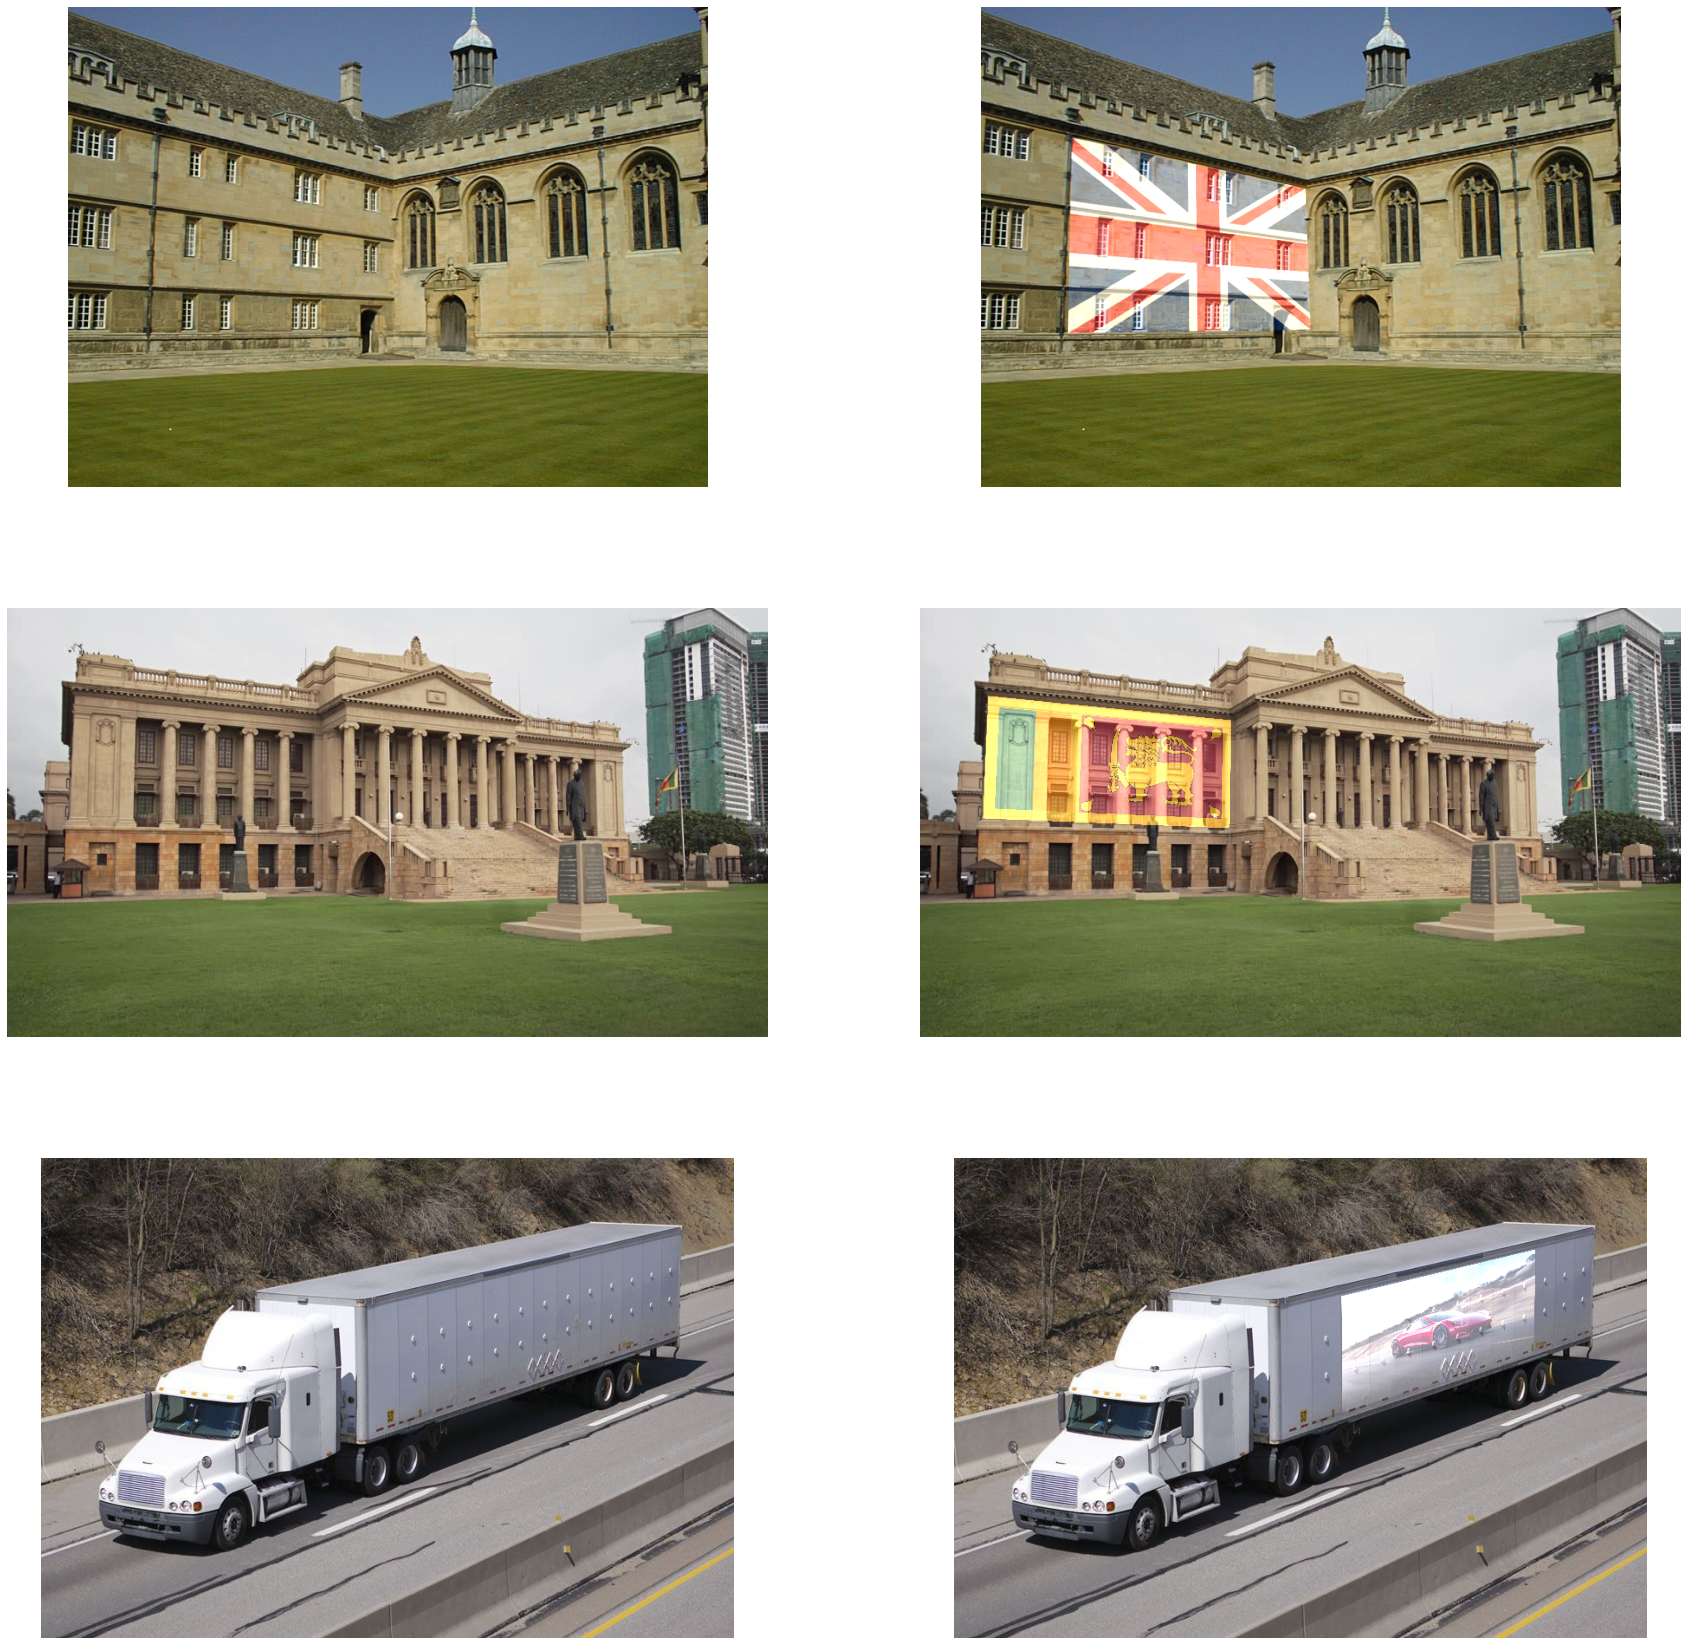

In [136]:
import cv2 as cv
point_matrix = np.zeros((4,2),dtype=np.float32)
counter = 0

def mouseClicks(event,x,y,flags,params):# getting points by mouse-clicking
    global counter
    if event == cv.EVENT_LBUTTONDOWN:
        point_matrix[counter] = x,y
        counter = counter + 1
    if counter==4:
        cv.destroyAllWindows()
        counter=0

def gettingPoints(im, win_name):
    cv.imshow(win_name,im)
    cv.setMouseCallback(win_name,mouseClicks)
    cv.waitKey(0)
    cv.destroyAllWindows()

def BGR2RGB(im):
    return cv.cvtColor(im,cv.COLOR_BGR2RGB)

fig , ax = plt.subplots(3 , 2 ,figsize=(30,30))

for i in range(1,4):
    img = cv.imread(r'im{}.jpg'.format(i))
    assert img is not None
    img2 = cv.imread(r'f{}.png'.format(i))
    assert img2 is not None

    gettingPoints(img, 'img{}'.format(i))

    H = cv.getPerspectiveTransform(np.array([[0, 0],[np.shape(img2)[1],0],[0,np.shape(img2)[0]],[np.shape(img2)[1],np.shape(img2)[0]]],dtype=np.float32), point_matrix)
    warped_img2 = cv.warpPerspective(img2, H,(np.shape(img)[1],np.shape(img)[0]))
    result = cv.addWeighted(img, 1, warped_img2, 0.6, 0)

    ax[i-1,0].imshow(BGR2RGB(img))
    ax[i-1,1].imshow(BGR2RGB(result))
    for k in range(2):
        ax[i-1,k].axis('off')
plt.show()

no of matches = 103


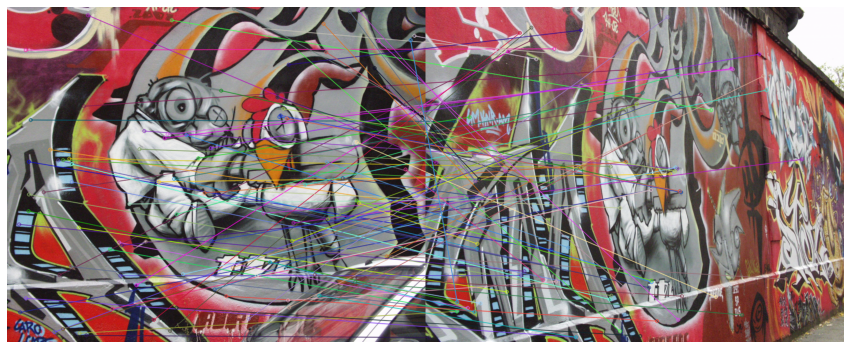

In [137]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt


def matchSIFTfeatures(img1,img2,ratio):
    img1 = cv.imread(r'{}.ppm'.format(img1))
    img2 = cv.imread(r'{}.ppm'.format(img2))

    sift = cv.xfeatures2d.SIFT_create()

    keypoints1, descriptors1 = sift.detectAndCompute(img1,None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2,None)

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)
    
    flann = cv.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(descriptors1,descriptors2,k=2)
    pts1,pts2,good = [],[],[]
    
    for m,n in matches:
        if m.distance < ratio*n.distance:
            pts1.append(keypoints1[m.queryIdx].pt)
            pts2.append(keypoints2[m.trainIdx].pt)
            good.append([m])

    pts1 = np.float32(pts1)
    pts2 = np.float32(pts2)
    return img1,img2,keypoints1,keypoints2,pts1,pts2,good

img_1,img_5,keypoints1,keypoints2,pts1,pts2,good = matchSIFTfeatures("img1","img5",0.75) # compute & match SIFT features

# plotting
img3 = cv.drawMatchesKnn(img_1,keypoints1,img_5,keypoints2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
img3 = cv.cvtColor(img3, cv.COLOR_BGR2RGB)
print("no of matches =",len(good))
plt.figure(figsize=(15,10))
plt.imshow(img3)
plt.axis('off')
plt.show()


In [161]:
def isSiftInlier(p1,p2,H,T):    # check inliers
    P = np.matmul(H,np.append(p1,1))
    P=P/P[-1]
    P = P[:2]-p2
    dis = np.sqrt(P[0]**2 + P[1]**2)
    if dis <= T:
        return True
    else:return False

def InlierCount(points1, points2, H, T):    # calculate inlier count
    count=0
    a=points1.shape[0]
    inliers1 = np.zeros((1,2))
    inliers2 = np.zeros((1,2))
    for i in range(a):
        if isInlier(points1[i],points2[i],H,T):
            count+=1
            if not inliers1.any():
                inliers1[0] = points1[i]
                inliers2[0] = points2[i]
            else:
                inliers1 = np.concatenate((inliers1, [points1[i]]), axis=0)
                inliers2 = np.concatenate((inliers2, [points2[i]]), axis=0)
    return count,inliers1,inliers2

def randomSample(points1, points2, n):  # Selecting a random rand_sample 
    rand_sample = np.random.choice(np.shape(points1)[0],n,replace=False)
    x1 = np.zeros([n,2])
    x2 = np.zeros([n,2])
    for i in range(n):
        x1[i]=points1[rand_sample[i]]
        x2[i]=points2[rand_sample[i]]
    return x1,x2

def calculateHomography(points1,points2):
    A = np.zeros((8,9))
    for i in range(4):  #creating the vector A
        A[(i*2),3:6] = np.append(points1[i],[1]); A[i*2,6:] = -points2[i,1]*np.append(points1[i],[1])
        A[(i*2)+1,:3] = np.append(points1[i],[1]); A[(i*2)+1,6:] = -points2[i,0]*np.append(points1[i],[1])
    B=np.matrix(A)
    u,s,v = np.linalg.svd(B)
    h= np.reshape(v[8],(3,3))
    h=(h/h.item(8))
    h=np.array(h)
    return h

def RANSAC(iterations,point_set1,point_set2,T): # compute using RANSAC
    max_inlier_count=0
    for k in range(iterations):
        p1,p2 = randomSample(point_set1, point_set2, 4)
        H = calculateHomography(p1,p2)
        no,a1,a2 = InlierCount(point_set1,point_set2,H,T)
        if no > max_inlier_count:
            max_inlier_count = no
            bestH = H
            ar1,ar2,pp1,pp2 = a1, a2,p1,p2
    return max_inlier_count, bestH, ar1, ar2,pp1,pp2

m,H1to5,A1,A2,xx,yy = RANSAC(10000,pts1,pts2,5) # H1to5 - img1 to img5 computed homography
print("\nComputed homography =", H1to5)


Computed homography = [[ 6.89907561e-01  2.68711066e-01  9.49631604e+01]
 [-2.43773088e-01  1.12433353e+00  1.16086979e+02]
 [ 1.98618269e-04  3.42869510e-05  1.00000000e+00]]


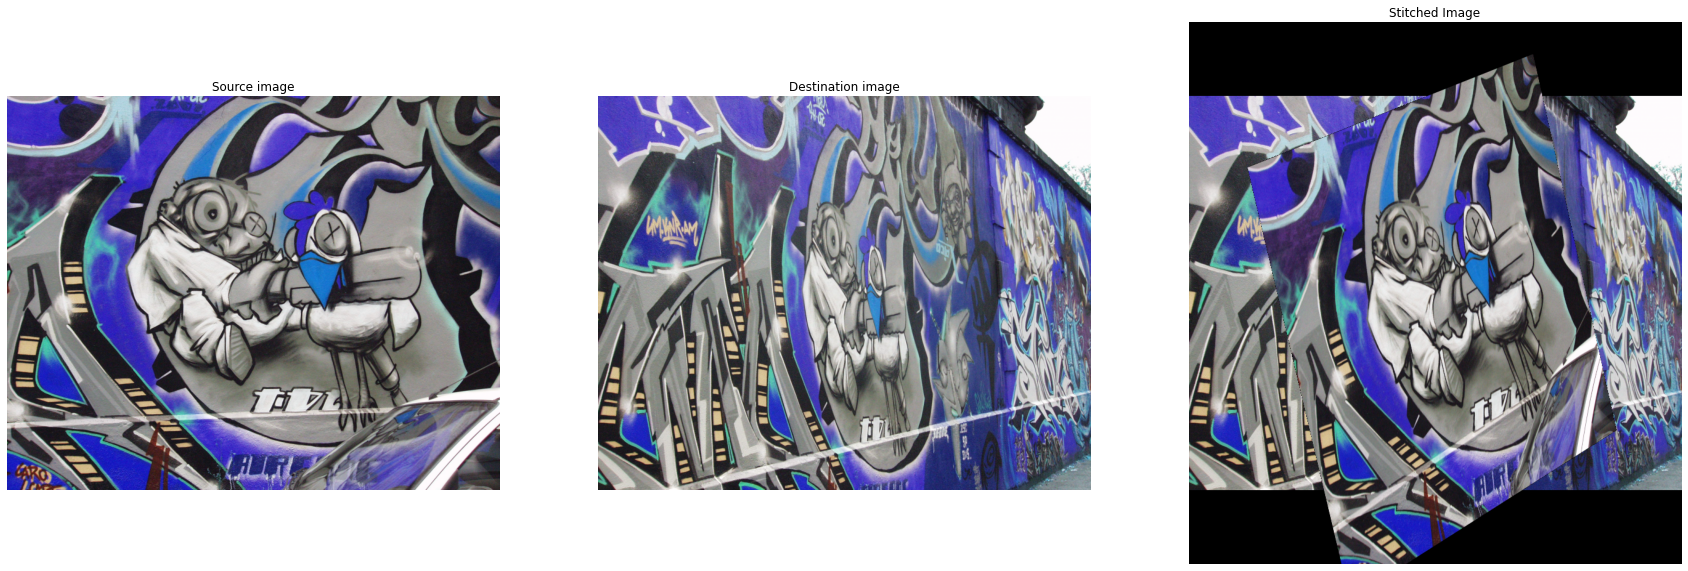

In [165]:
def stitching():
    frame = np.zeros((img_5.shape[0]+240, img_5.shape[1]))
    H_t = np.array([[1, 0, 0], [0, 1, 120], [0, 0, 1]], dtype=float)
    img_1_ = cv.add(img_1, 1)
    img1 = cv.warpPerspective(img_5, H_t, frame.shape[1::-1])
    img2 = cv.warpPerspective(img_1_, H_t @ H1to5, frame.shape[1::-1])

    rows, columns, channels = img2.shape
    ro = img1[0:rows, 0:columns]

    img2gray = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
    rt, mask = cv.threshold(img2gray, 0, 255, cv.THRESH_BINARY)
    mask_inv = cv.bitwise_not(mask)

    img1_bg = cv.bitwise_and(ro, ro, mask=mask_inv)

    img2_fg = cv.bitwise_and(img2, img2, mask=mask)

    dst = cv.add(img1_bg, img2_fg)
    img1[0:rows, 0:columns] = dst
    fig, ax = plt.subplots(1, 3, figsize=(30, 10))

    ax[0].imshow((eval('img_1_')))
    ax[0].set_title('Source image')
    ax[0].axis('off')
    
    ax[1].imshow((eval('img_5')))
    ax[1].set_title('Destination image')
    ax[1].axis('off')    

    ax[2].imshow((eval('img1')))
    ax[2].set_title('Stitched Image')
    ax[2].axis('off')
    plt.show()


stitching()
